# Equity Options Portfolio Optimization:
**Authors:** William Lester, Luke Rutherford, Dylan Kynoch, Henry Daniel \
**Start Date:** 4/17/2024 \
**Last Updated:** 4/19/2024

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
import yfinance as yf
from datetime import datetime
import QuantLib as ql
from scipy.optimize import minimize
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
start_date,end_date="2023-04-19",'2024-04-19'
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

# tickers = [
#     "XLC", "GOOG", "TMUS", "EA", "CMCSA", # Comms
#     "MCD", "BKNG", "NKE", "SBUX", # Cons. Disc
#     "XLP", "TGT", "MO", # Cons. Staples
#     "XLE", "XOM", "CVX", "COP", "EOG", "PXD", "WMB", # Energy
#     "XLF", "JPM", "V", "MA", "SPGI", "PGR", # Financials
#     "JNJ", "MRK", "TMO", "PFE", "AMGN", # Health
#     "CAT", "GE", "UNP", "RTX", "HON", "ETN", "UPS", "DE", "ADP", # Industrials
#     "LIN", "SHW", "ECL", "APD", "NUE", "CTVA", "MLM", # Materials
#     "XLRE", "AMT", "EQIX", "WELL", "SPG", "O", "PSA", "CCI", "CSGP", # Real Estate
#     "XLK", "AVGO", "ORCL", # Tech
#     "XLU", "SO", "AEP", "D", "EXC", # Utilities
# ]
tickers = ['XLC','MCD','XLP','XLE','JPM','JNJ','CAT','LIN','XLRE','XLK','XLU']
#tickers=['FI','STLD','GOOG','BKNG','XOM']
ex_stock='JPM'

[*********************100%%**********************]  11 of 11 completed


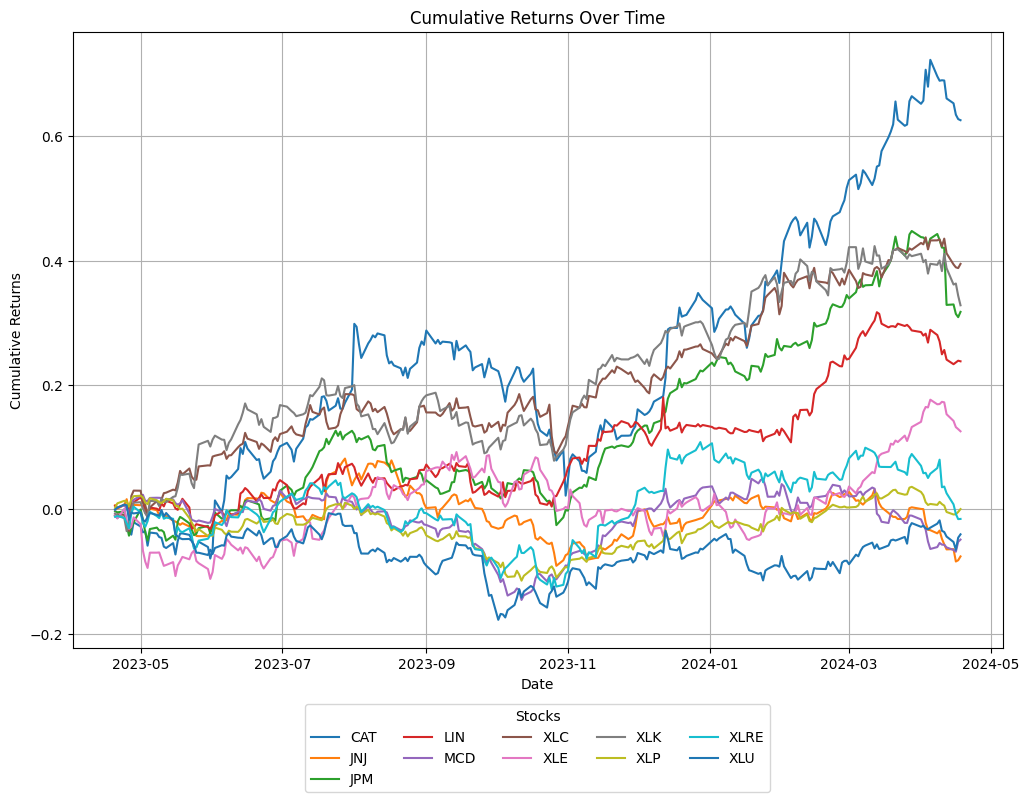

In [3]:
stock_df=dat_func.get_price_df(tickers,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)
vis.plot_cumulative_returns(returns_df)

In [4]:
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10').iloc[-1]/100

In [5]:
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate,leverage_limit=0.2)
init_weights=init_weights.round(3)
print('Initial Port Returns:',init_ret)
print('Initial Port Volatility:',init_std)
print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

Initial Port Returns: 0.218537363644384
Initial Port Volatility: 0.06958113192238045
Initial Port Sharpe: 2.53570700518647
Optimal Weights: {'CAT': 0.147, 'JNJ': -0.083, 'JPM': 0.161, 'LIN': 0.105, 'MCD': -0.063, 'XLC': 0.2, 'XLE': -0.025, 'XLK': 0.01, 'XLP': -0.004, 'XLRE': -0.2, 'XLU': -0.0}


## Initial Portfolio Simulation:
### Geometric Brownian Motion: 

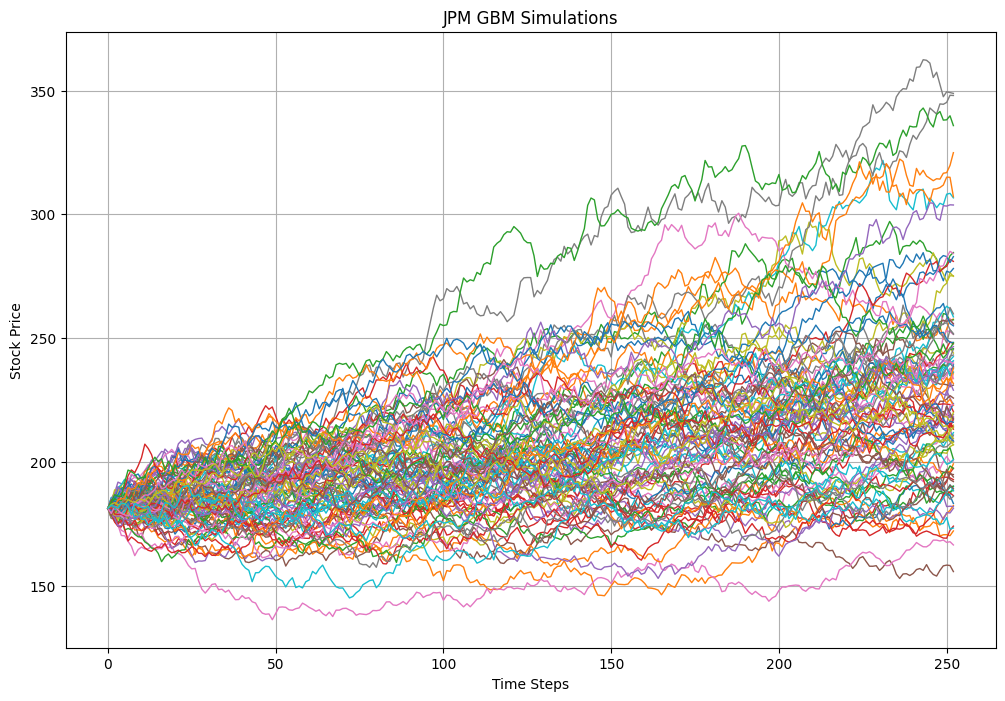

In [6]:
gpc_gbm=dat_func.simulate_gbm(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
vis.plot_paths(gpc_gbm,f'{ex_stock} GBM',False)

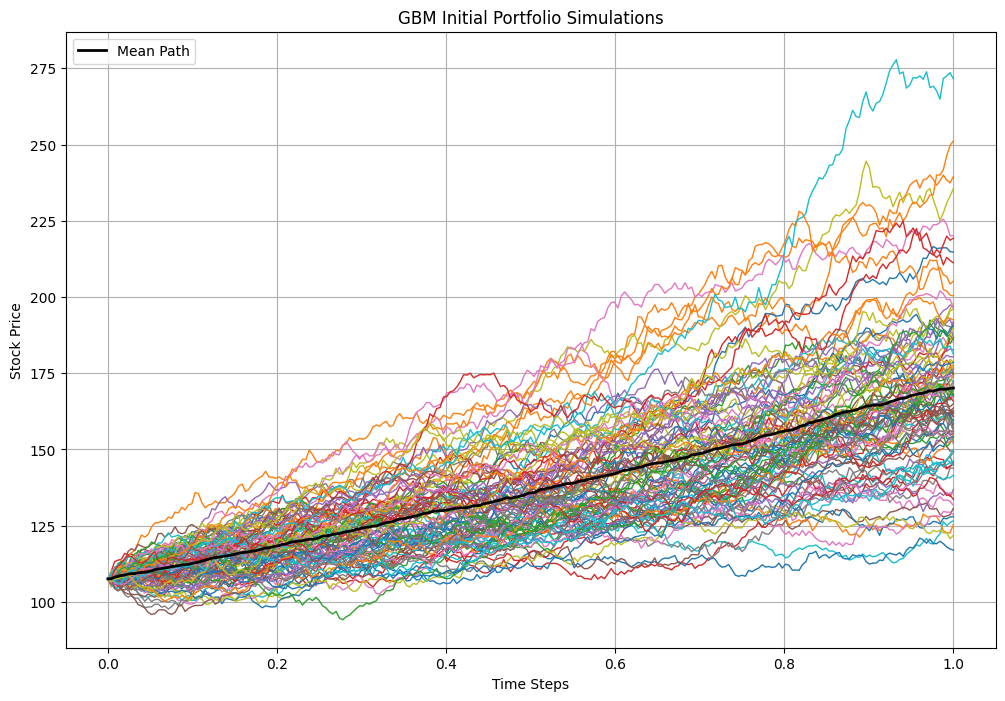

In [7]:
gbm_init_port=dat_func.simulate_gbm_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(gbm_init_port.iloc[:100],'GBM Initial Portfolio',True)

In [8]:
gbm_ret=(gbm_init_port.mean(axis=0).iloc[-1]-gbm_init_port.mean(axis=0).iloc[0])/gbm_init_port.mean(axis=0).iloc[0]
print(f'GBM Initial Portfolio Return: {round(gbm_ret*100,2)}%')

GBM Initial Portfolio Return: 57.85%


### Merton Jump Diffusion: 

In [9]:
# Estimate the number of jumps, mean jump, and vol of jumps
gpc_lambda_,gpc_m,gpc_v=dat_func.estimate_merton_params(returns_df[ex_stock])

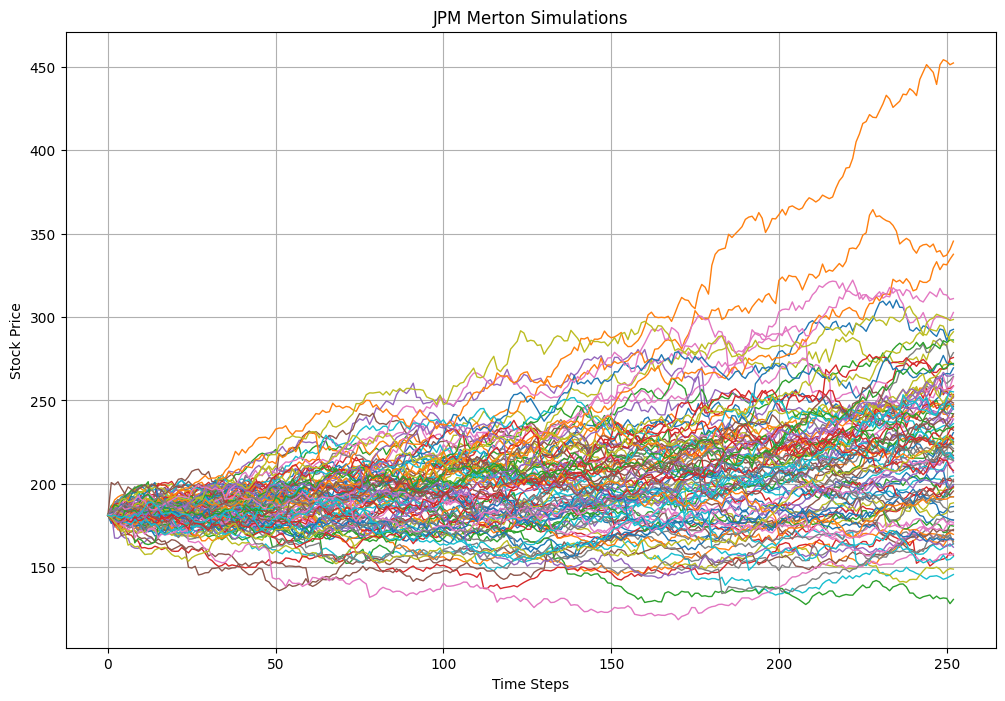

In [10]:
gpc_merton=dat_func.simulate_merton(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,gpc_lambda_,gpc_m,gpc_v,1/252,100)
vis.plot_paths(gpc_merton,f'{ex_stock} Merton')

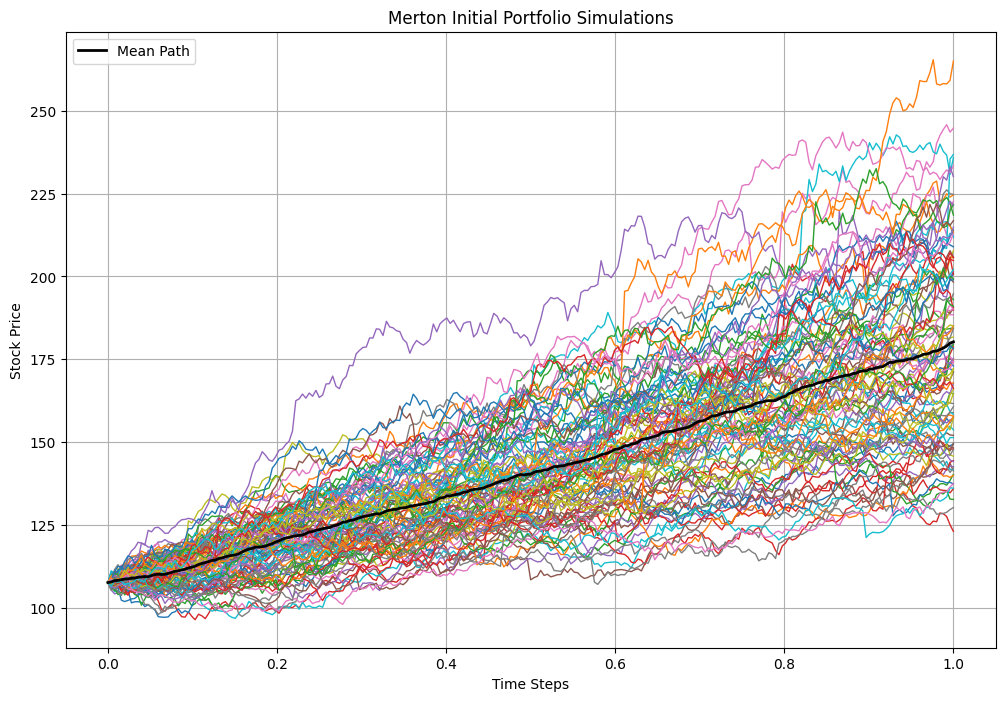

In [11]:
merton_init_port=dat_func.simulate_merton_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(merton_init_port.iloc[:100],'Merton Initial Portfolio',True)

In [12]:
merton_ret=(merton_init_port.mean(axis=0).iloc[-1]-merton_init_port.mean(axis=0).iloc[0])/merton_init_port.mean(axis=0).iloc[0]
print(f'Merton Initial Portfolio Return: {round(merton_ret*100,2)}%')

Merton Initial Portfolio Return: 68.23%


### Constant Elasticity of Variance (CEV): 

Estimated JPM CEV Parameters: mu=0.0011665848585691416, std=0.004277708501308833, gamma=1.1801759740864266


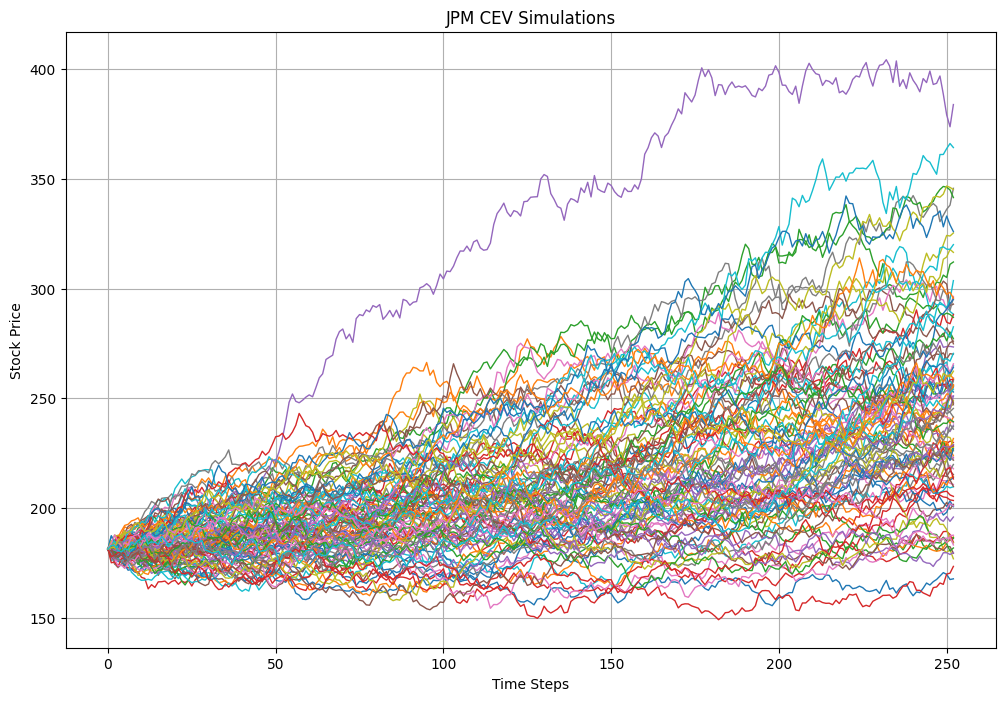

In [13]:
cev_ex_params=dat_func.estimate_cev_params(stock_series=stock_df[ex_stock])
simulated_prices = dat_func.simulate_cev(stock_df[ex_stock][-1],cev_ex_params[0]*252,cev_ex_params[1]*np.sqrt(252), gamma=cev_ex_params[2], T=1)
vis.plot_paths(simulated_prices[:100],f'{ex_stock} CEV')

Estimated CAT CEV Parameters: mu=0.001952159783464397, std=2.4736658328508514, gamma=0.10266558855207714
Estimated JNJ CEV Parameters: mu=-0.00020306152421653963, std=5.997809981732582e-05, gamma=2.0
Estimated JPM CEV Parameters: mu=0.0011665848585691416, std=0.004277708501308833, gamma=1.1801759740864266
Estimated LIN CEV Parameters: mu=0.0008649340875263009, std=0.20180587722476112, gamma=0.5021241274112596
Estimated MCD CEV Parameters: mu=-0.00019891094642633423, std=0.1751861946315709, gamma=0.47302666170442037
Estimated XLC CEV Parameters: mu=0.001233058855749594, std=0.7290687083931617, gamma=0.0
Estimated XLE CEV Parameters: mu=0.00044846188556654803, std=1.006685899006651, gamma=0.0
Estimated XLK CEV Parameters: mu=0.0010732132013120989, std=0.1725011631680933, gamma=0.4724094574094566
Estimated XLP CEV Parameters: mu=-1.986133111748464e-05, std=0.4688248335111006, gamma=0.0
Estimated XLRE CEV Parameters: mu=-0.00012692179149660586, std=0.422599512605979, gamma=0.0
Estimated XL

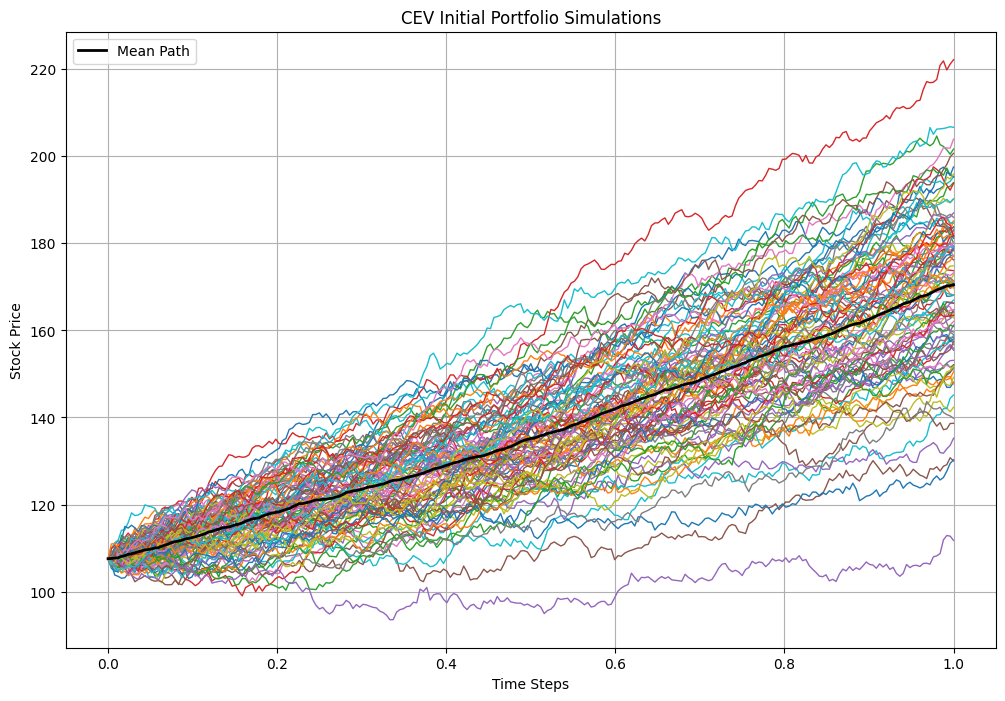

In [14]:
cev_init_port=dat_func.simulate_cev_portfolio(stock_df,init_weights)
vis.plot_paths(cev_init_port.iloc[:100],'CEV Initial Portfolio',True)

In [15]:
cev_ret=(cev_init_port.mean(axis=0).iloc[-1]-cev_init_port.mean(axis=0).iloc[0])/cev_init_port.mean(axis=0).iloc[0]
print(f'CEV Initial Portfolio Return: {round(cev_ret*100,2)}%')

CEV Initial Portfolio Return: 58.43%


### Heston Model:

Estimated JPM Heston Parameters: theta=0.07507922660370671, kappa=3.7049552190316963, sigma=0.6077771187320078, rho=-0.9998663253174258, v0=0.012313682496271218


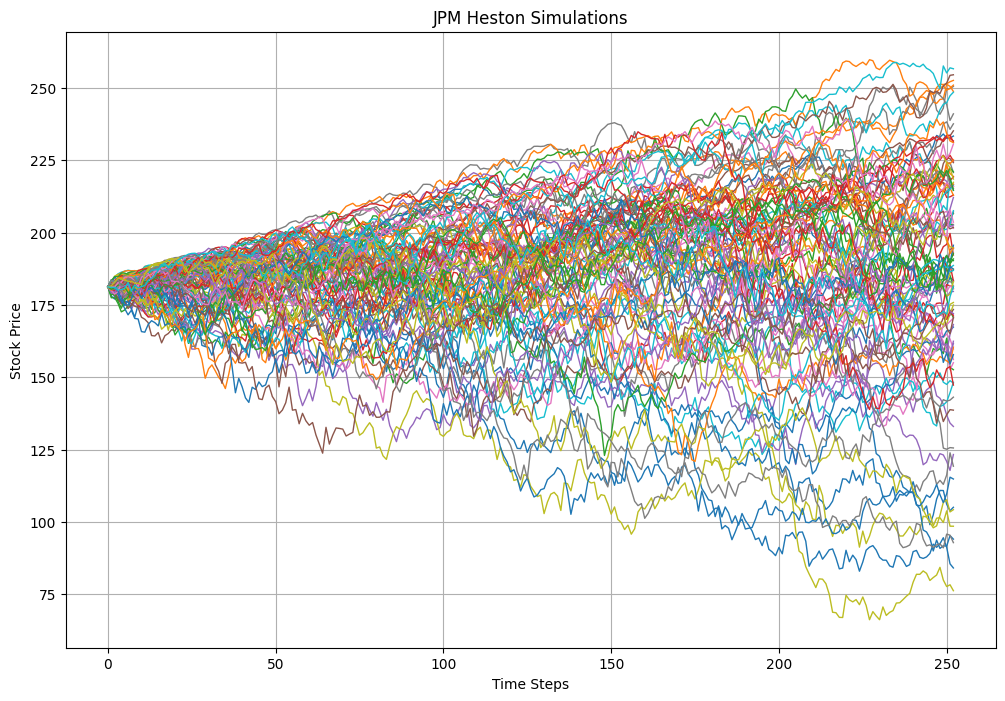

In [16]:
ex_heston_param=dat_func.estimate_heston_params(ex_stock,end_date,stock_df,risk_free_rate)
ex_heston_prices=dat_func.simulate_heston(ex_heston_param, stock_df[ex_stock][-1], risk_free_rate)
vis.plot_paths(ex_heston_prices[:100],f'{ex_stock} Heston')

Estimated CAT Heston Parameters: theta=0.12637546823542162, kappa=2.6386751181278774, sigma=0.5832234281169831, rho=-0.9999999224180912, v0=0.015075374667229713
Estimated JNJ Heston Parameters: theta=5.059508165157974, kappa=1.4068359420907524, sigma=8.548417551290353, rho=-0.9993166396609344, v0=0.6165988704917189
Estimated JPM Heston Parameters: theta=0.07507950806736312, kappa=3.704931323153846, sigma=0.6077770567788268, rho=-0.9998664681614664, v0=0.012313681472240288
Estimated LIN Heston Parameters: theta=0.8743343752223227, kappa=13.405008132781512, sigma=0.28375417085995663, rho=-0.9999994919475312, v0=0.007903868415963794
Estimated MCD Heston Parameters: theta=0.13831692381240543, kappa=3.710218114323051, sigma=0.37227249063662515, rho=-0.9999903667206451, v0=0.014194539915299995
Estimated XLC Heston Parameters: theta=0.12271133538749085, kappa=6.958238541806867, sigma=0.6244590130527057, rho=-0.999999932198286, v0=0.01239047697425378
Estimated XLE Heston Parameters: theta=2.51

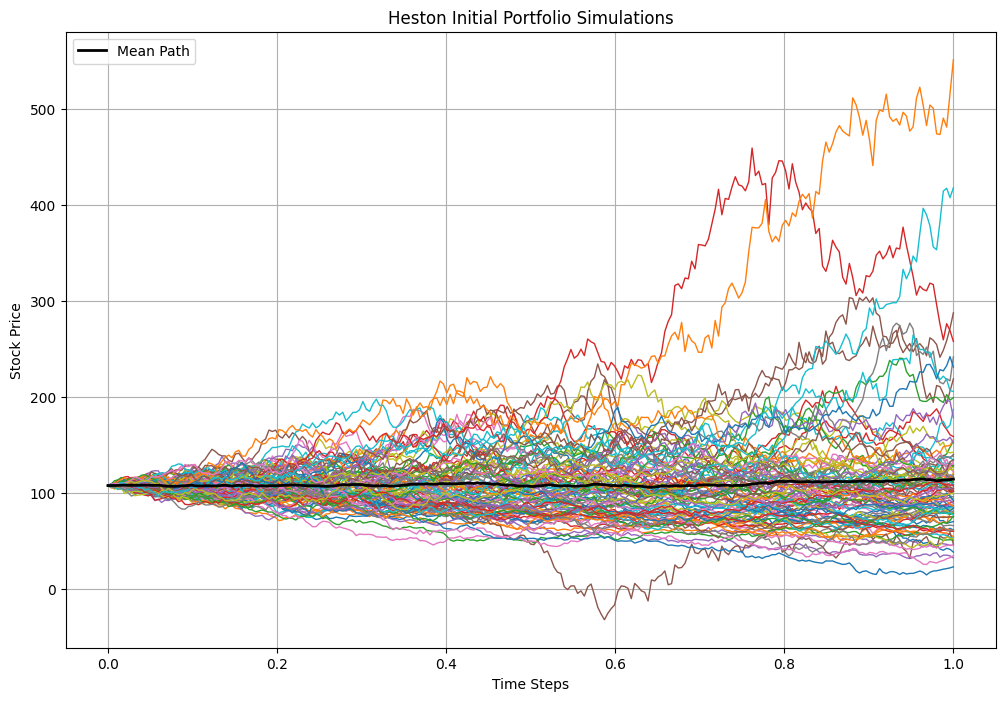

In [17]:
heston_init_port=dat_func.simulate_heston_portfolio(stock_df,init_weights,risk_free_rate)
vis.plot_paths(heston_init_port.iloc[:100],'Heston Initial Portfolio',True)

In [18]:
heston_ret=(heston_init_port.mean(axis=0).iloc[-1]-heston_init_port.mean(axis=0).iloc[0])/heston_init_port.mean(axis=0).iloc[0]
print(f'Heston Initial Portfolio Return: {round(heston_ret*100,2)}%')

Heston Initial Portfolio Return: 4.28%


## Simulation Portfolio:

In [19]:
sim_port_results=dat_func.calculate_simulate_portfolio(tickers,end_date,stock_df,returns_df,risk_free_rate,0.2,10)
sim_port_weights={tick:sim_port_results.x[i] for i,tick in enumerate(tickers)}
sim_port_weights

Estimated XLC CEV Parameters: mu=0.001233058855749594, std=0.7290687083931617, gamma=0.0
Estimated XLC Heston Parameters: theta=0.12271133538749085, kappa=6.958238541806867, sigma=0.6244590130527057, rho=-0.999999932198286, v0=0.01239047697425378
Estimated MCD CEV Parameters: mu=-0.00019891094642633423, std=0.1751861946315709, gamma=0.47302666170442037
Estimated MCD Heston Parameters: theta=0.11574753077873974, kappa=3.863994557491722, sigma=0.34725784700877904, rho=-0.9999992209248068, v0=0.01605418426560363
Estimated XLP CEV Parameters: mu=-1.986133111748464e-05, std=0.4688248335111006, gamma=0.0
Estimated XLP Heston Parameters: theta=0.23650675883214456, kappa=6.360565535622442, sigma=0.6607171253507981, rho=-0.9999953266133746, v0=0.011261282116648208
Estimated XLE CEV Parameters: mu=0.00044846188556654803, std=1.006685899006651, gamma=0.0
Estimated XLE Heston Parameters: theta=2.3185111322298373, kappa=101.16959412166409, sigma=1.7937834586171117e-08, rho=-0.7372469650486522, v0=0

{'XLC': -6.233594099868339e-08,
 'MCD': -2.0548330175570543e-07,
 'XLP': -1.974055952691873e-07,
 'XLE': 0.2,
 'JPM': 0.2,
 'JNJ': 3.454775047978248e-08,
 'CAT': 0.2,
 'LIN': 1.761014546592456e-07,
 'XLRE': 0.2,
 'XLK': -2.1196734985507095e-07,
 'XLU': 0.19999999999994936}